In [25]:
### PROCEDURES ###
#   Configerations          (HOME)
#        |
#        |
# Galaxy distribution       (HOME)
#        |
#        |
#    CosmoSIS               (COSMOSIS)
#        |
#        |
#    get gal distr          (HOME)
#    get z_coords_in bins   (HOME)
#    get photo-z PDF        (HOME)
#    get chi                (COSMOSIS)
#    get h                  (COSMOSIS)
#    get P_k_h_non_lin      (COSMOSIS)
#    get C_gg, C_GG, C_Gg   (COSMOSIS)
#    get C_IG, C_II, C_Ig   (COSMOSIS) #pending
#        |
#        |
#   Compute lensing kernels (HOME)
#   Interpolate P_k_h       (HOME)
#        |
#   Limber and tests        (HOME)
#        |
#   Compute eta             (HOME)
#   Compute Q with limber   (HOME)

In [26]:
print('Started. Loading libraries ... ')
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
import fitsio as fio
import pickle

from interpolation_fncs import *
from io_fncs import *
from gal_distr import *
from basic_cosmo_lensing_fncs import *
# from limber_integral import *



########################################
#io
########################################
outputfolder       = 'chi_based_SC'
outputparentfolder = '/hpc/group/cosmology/alanzhou/IA-Project/IA-Self-Calib-Data/'
outputpath         = os.path.join(outputparentfolder, outputfolder)
create_dir(outputpath)
print('   - output path set to %s'%(outputpath))



########################################
#constants
########################################
light_speed = 299792.458 #km/s
H0 = 67.26 #H0 (km/s/Mpc)
d_horiz = light_speed/H0 #c/H0, c in km/s
Omega0 = 0.3141 #present day matter density in unit of critical density
OmegaLambda = 1-0.3141
Omegak = 1-Omega0-OmegaLambda
deltaz = 0.2 #redshift bin width
#in integration 1 redshift is broken into z_res intervals
#for z_max = 4, zres = 400 ~20sec/run
z_bin_num = 20
z_max = z_bin_num*deltaz+2 #+2 redshift reserved for photometric error
z_res = 100 
gal_distr_model = 'z2exp_gausPDF'

save_config_file(os.path.join(outputpath,'values.txt'),
                 ['Identifier',outputfolder,
                  'H0, [km/s/Mpc]',H0,
                  'horizon distance = c/H0, [Mpc]',d_horiz,
                  'speed of light [km/s]',light_speed,
                  'Omega0',Omega0,
                  'OmegaLambda',OmegaLambda,
                  'Omegak',Omegak,
                  'deltaz',deltaz,
                  'number of galaxy redshift bins',z_bin_num,
                  'max z used in calculations',z_max,
                  'z resolution [intervals/ unit z]',z_res,
                  'z resolution spacing [z]',1/z_res,
                  'galaxy distribution model',gal_distr_model,
                  'output path', outputpath])

print('   - Setup complete. ')
print('   - %i photometric redshift bins; computational z resolution is %1.5f.' %(z_bin_num,1/z_res))


########################################################
#Gal distribution + Run CosmoSIS. #
########################################################
#get the galaxy distribution
print('Getting the galaxy distribution, assuming ' + gal_distr_model)
get_gal_distr(z_bin_num,deltaz,z_res,z_max,gal_distr_model,outputpath)

#run CosmoSIS
#run the pow_specs.ini with CosmoSIS from terminal
#the cosmoSIS has to be set up with the same cosmology
#the max z, max ell in CAMB must be at least span the Z_MID's range
print('Assuming CosmoSIS has been run.')
print('Starting data analysis...')



########################################################
#Loading data from prev calculations and CosmoSIS
########################################################
print('Loading data...')



print('   - Loading the galaxy distribution')
gal_distr_folder = os.path.join(outputpath,'n_z')
#Pickle data, may later lead to 
# ValueError: Big-endian buffer not supported on little-endian compiler
# n_true_z_file = open(os.path.join(gal_distr_folder,'n_true_z.pkl'), 'rb')
# n_true_z_data = pickle.load(n_true_z_file)
# n_true_z_file.close()
# n_photo_z_file = open(os.path.join(gal_distr_folder,'n_photo_z.pkl'), 'rb')
# n_photo_z_data = pickle.load(n_photo_z_file)
# n_photo_z_file.close()
n_true_z_data  = pd.read_csv(os.path.join(gal_distr_folder,'n_true_z.csv'))
n_photo_z_data = pd.read_csv(os.path.join(gal_distr_folder,'n_photo_z.csv'))  

Z_MID = n_true_z_data['Z_MID']
if not np.array_equal(Z_MID,n_photo_z_data['Z_MID']):raise Exception("true z Z_MID incompatible with photo z Z_MID")

    

print('   - Loading photo-z PDFs for each redshift bins, and calculating coordinates inside z bins')
#photozPDF[ztrue,zphoto]
test_photo_z_PDF = np.loadtxt(os.path.join(gal_distr_folder,'photo_z_PDF_%.2i.txt'%(1)))

#photo_z_total[bin#,ztrue,zphoto]
photo_z_total = np.empty((z_bin_num,test_photo_z_PDF.shape[0],test_photo_z_PDF.shape[1]))
#z_i_list_total[bin#,z_coord]
z_i_list_total = np.empty((z_bin_num,test_photo_z_PDF.shape[1]))
#n_i_photo_z_total[bin#,z_coord_in_ith_bin]
n_i_photo_z_total = np.empty((z_bin_num,test_photo_z_PDF.shape[1])) #slice of the n_photo_z vector, just psanning the ith redshift bin

plt.figure(figsize=(6,6))
test_true_z = 2
test_true_z_index = int(2*z_res)

for i in range(z_bin_num):
    z_lowerbound = i*deltaz
    z_upperbound = (i+1)*deltaz
    #a slice of the z_list that lies withIN the ith z bin range
    #taking z_mid values
    z_i_list_total[i] = Z_MID[int(z_lowerbound*z_res):int(z_upperbound*z_res)].to_numpy()
    n_i_photo_z_total[i] = (n_photo_z_data['BIN%i'%(i+1)].to_numpy())[int(z_lowerbound*z_res):int(z_upperbound*z_res)]
    photo_z_total[i] = np.loadtxt(os.path.join(gal_distr_folder,'photo_z_PDF_%.2i.txt'%(i+1)))
    
    
    plt.plot(z_i_list_total[i],photo_z_total[i,test_true_z_index],label='BIN%i'%(i+1))
plt.title('photo-z PDF(true_z=%1.1f,photo_z)'%(Z_MID[test_true_z_index]))
plt.xlabel('photo z')
plt.ylabel('photo z PDF')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(gal_distr_folder,'photo_z_PDF_test.png'))
plt.close()
    


print('   - Loading distances from CosmoSIS')
# z_CosmoSIS         [redshift]
# chi_CosmoSIS       [Mpc]
# little_h_CosmoSIS  [100 km/s/Mpc] 
distance_folder_CosmoSIS = os.path.join(outputpath,'cosmoSIS_output/distances')
with open(os.path.join(distance_folder_CosmoSIS,'z.txt'),'rb') as f:
    z_CosmoSIS = np.loadtxt(f)
with open(os.path.join(distance_folder_CosmoSIS,'d_m.txt'),'rb') as f:
    chi_CosmoSIS = np.loadtxt(f)
with open(os.path.join(distance_folder_CosmoSIS,'h.txt'),'rb') as f:
    little_h_CosmoSIS = np.loadtxt(f)
little_h_CosmoSIS = little_h_CosmoSIS*light_speed/100



print('   - Loading non-linear P(k,z) from CosmoSIS')
#get the power spectrum P(k,z) from CosmoSIS. (need non-linear spectrum)
#CosmoSIS unit: k is in (Mpc/h), P is in (h/Mpc)^3
#interpolating the P(k,z) to fit Z_MID
#matter_pow_p_k[z_index,kindex]
matter_power_folder = os.path.join(outputpath,'cosmoSIS_output/matter_power_nl')
with open(os.path.join(matter_power_folder, 'p_k.txt'),'rb') as f:
    matter_pow_p_k = np.loadtxt(f,delimiter = ' ') 
with open(os.path.join(matter_power_folder, 'k_h.txt'),'rb') as f:
    matter_pow_k_h = np.loadtxt(f,delimiter = ' ')
with open(os.path.join(matter_power_folder, 'z.txt'),'rb') as f:
    matter_pow_z = np.loadtxt(f,delimiter = ' ')



#load the angular GG,Gg,gg speactra from CosmoSIS
#the ell coordinates from the CosmoSIS outputs must be identical across spectra
#load the C_GG in angular space from CosmoSIS (shear-shear option)
print('   - Loading C_GG(ell) from CosmoSIS')
shear_cl_folder = os.path.join(outputpath,'cosmoSIS_output/shear_cl')
with open(os.path.join(shear_cl_folder,'ell.txt'),'rb') as f:
    ell_list = np.loadtxt(f)
C_GG_ii = np.empty((z_bin_num,len(ell_list)))
plt.subplots(figsize=(6,6))
for i in range(z_bin_num):
    with open(os.path.join(shear_cl_folder,'bin_%i_%i.txt'%(i+1,i+1)),'rb') as f:
        C_GG_ii[i] = np.loadtxt(f)
    plt.plot(ell_list,C_GG_ii[i],label='C_GG_ii, i=%i'%(i+1))
plt.xlabel('ell')
plt.ylabel('C_GG_ii')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 0),loc='lower left') #bbox(x,y)
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'combined_C_GG_ii.png'))
plt.close()

#load the C_Gg in angular space from CosmoSIS (position-shear option)
print('   - Loading C_Gg(ell) from CosmoSIS')
galaxy_shear_cl_folder = os.path.join(outputpath,'cosmoSIS_output/galaxy_shear_cl')
with open(os.path.join(galaxy_shear_cl_folder,'ell.txt'),'rb') as f:
    ell_list_test = np.loadtxt(f)
if not np.array_equal(ell_list, ell_list_test): raise Exception('ell coordinates differ for different CosmoSIS angular spectra')
C_Gg_ii = np.empty((z_bin_num,len(ell_list)))
plt.subplots(figsize=(6,6))
for i in range(z_bin_num):
    with open(os.path.join(galaxy_shear_cl_folder,'bin_%i_%i.txt'%(i+1,i+1)),'rb') as f:
        C_Gg_ii[i] = np.loadtxt(f)
    plt.plot(ell_list,C_Gg_ii[i],label='C_Gg_ii, i=%i'%(i+1))
plt.xlabel('ell')
plt.ylabel('C_Gg_ii')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 0),loc='lower left') #bbox(x,y)
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'combined_C_Gg_ii.png'))
plt.close()

#load the C_gg in angular space from CosmoSIS (position-position option)
print('   - Loading C_gg(ell) from CosmoSIS')
galaxy_cl_folder = os.path.join(outputpath,'cosmoSIS_output/galaxy_cl')
with open(os.path.join(galaxy_cl_folder,'ell.txt'),'rb') as f:
    ell_list_test = np.loadtxt(f)
if not np.array_equal(ell_list, ell_list_test): raise Exception('ell coordinates differ for different CosmoSIS angular spectra')
C_gg_ii = np.empty((z_bin_num,len(ell_list)))
plt.subplots(figsize=(6,6))
for i in range(z_bin_num):
    with open(os.path.join(galaxy_cl_folder,'bin_%i_%i.txt'%(i+1,i+1)),'rb') as f:
        C_gg_ii[i] = np.loadtxt(f)
    plt.plot(ell_list,C_gg_ii[i],label='C_gg_ii, i=%i'%(i+1))
plt.xlabel('ell')
plt.ylabel('C_gg_ii')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 0),loc='lower left') #bbox(x,y)
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'combined_C_gg_ii.png'))
plt.close()



########################################
#Preliminary Calculations
########################################
print('Starting preliminary calculations')
create_dir(os.path.join(outputpath,'Preliminary_calculations'))



    ################################################
    #Converting gal distributions from z to chi
    ################################################
print('   - Converting distances data into functions')
z_chi_func = interpolate.interp1d(chi_CosmoSIS,z_CosmoSIS,kind='linear') 
little_h_chi_func = interpolate.interp1d(chi_CosmoSIS,little_h_CosmoSIS,kind='linear') 
chi_z_func = interpolate.interp1d(z_CosmoSIS,chi_CosmoSIS,kind='linear') 

#Constructing the chi_axis vector
#All subsequent calculations will be done on chi_axis as the distance measure
chi_Z_MID = chi_z_func(Z_MID) #the corresponding chi values for Z_MID
#re-regularize the chi axis to be of equal interval in the same definition domain with same number of histogram bins
#this will be used in the galaxy distribution file
CHI_MID = (np.arange(len(Z_MID))+0.5)*chi_z_func(max(Z_MID))/len(Z_MID)
chi_interval = CHI_MID[1]-CHI_MID[0] #uniform intervals by construnction, width of each histogram bin in gal distr.
print('   - chi interval used is %1.3f'%(chi_interval))

fig = plt.figure(figsize=(6,6))
plt.plot(z_CosmoSIS,chi_CosmoSIS,linestyle='dashed',color='black',label='CosmoSIS original output')
plt.plot(Z_MID,chi_Z_MID,color='red',label='interpolated at Z_MID')
plt.xlabel('redshift z')
plt.title('chi [Mpc]')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'Preliminary_calculations/chi_z.png'))
plt.close()

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(211)
ax1.plot(z_CosmoSIS,little_h_CosmoSIS,color='black',label='CosmoSIS original output')
plt.legend()
ax1.set_xlabel('z')
ax2 = fig.add_subplot(212)
ax2.plot(chi_z_func(z_CosmoSIS),little_h_CosmoSIS,color='black',linestyle='dashed',label='h_cosmosis vs. chi(z_cosmosis)')
ax2.scatter(CHI_MID,little_h_chi_func(CHI_MID),color='red',marker='o',s=4,label='h vs. chi at equal interval')
ax2.set_xlabel('chi [Mpc]')
plt.suptitle('h [100 km/s/Mpc]',y=1)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'Preliminary_calculations/little_h.png'))
plt.close()



print('   - Converting galaxy distribution in z-space to chi-space')
#use chi_axis to regularize the galaxy distribution
#change the table header for the chi datas to CHI_LOW, CHI_MID, CHI_HIGH...

#n_true/photo_chi_data are already pandas df
n_true_chi_data = n_true_z_data.copy(deep=True)
n_true_chi_data = n_true_chi_data.rename(columns={"Z_LOW": "CHI_LOW", "Z_MID": "CHI_MID", "Z_HIGH": "CHI_HIGH"},errors='raise')
n_true_chi_data['CHI_MID']  = CHI_MID
n_true_chi_data['CHI_LOW']  = CHI_MID-chi_interval/2
n_true_chi_data['CHI_HIGH'] = CHI_MID+chi_interval/2



for bin_index in range(z_bin_num):
    gal_distr_chi_func_bin_i = interpolate.interp1d(chi_Z_MID,n_true_chi_data['BIN%i'%(bin_index+1)],kind='linear',fill_value='extrapolate') #interp1d(x,f(x))
    n_true_chi_data['BIN%i'%(bin_index+1)] = gal_distr_chi_func_bin_i(CHI_MID)/(sum(gal_distr_chi_func_bin_i(CHI_MID)*chi_interval))

#n_true/photo_chi_data are already pandas df
n_photo_chi_data = n_photo_z_data.copy(deep=True)
n_photo_chi_data = n_photo_chi_data.rename(columns={"Z_LOW": "CHI_LOW", "Z_MID": "CHI_MID", "Z_HIGH": "CHI_HIGH"},errors='raise')
n_photo_chi_data['CHI_MID']  = CHI_MID
n_photo_chi_data['CHI_LOW']  = CHI_MID-chi_interval/2
n_photo_chi_data['CHI_HIGH'] = CHI_MID+chi_interval/2

for bin_index in range(z_bin_num):
    gal_distr_chi_func_bin_i = interpolate.interp1d(chi_Z_MID,n_photo_chi_data['BIN%i'%(bin_index+1)],kind='linear',fill_value='extrapolate') #interp1d(x,f(x))
    n_photo_chi_data['BIN%i'%(bin_index+1)] = gal_distr_chi_func_bin_i(CHI_MID)/(sum(gal_distr_chi_func_bin_i(CHI_MID)*chi_interval))

plt.subplots(figsize=(8,6))
for i in range(z_bin_num):
    plt.plot(CHI_MID, n_photo_chi_data['BIN%i'%(i+1)],label = 'PHOTO-CHI BIN%i'%(i+1))
    plt.plot(CHI_MID, n_true_chi_data['BIN%i'%(i+1)],linestyle='dashed',label = 'TRUE-CHI  BIN%i'%(i+1))
plt.xlabel('Chi [Mpc]')
plt.ylabel('galaxy redshift distribution')
plt.title('n(chi), normalized for each bin seperately')
#plt.legend(bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'n_z/combined_n_chi.png'))
plt.close()



    ########################################
    #Computing lensing kernels
    ########################################
print('   - Computing lensing kernels')
create_dir(os.path.join(outputpath,'lensing_kernels'))

#W_L_list[chi_L,chi_G], where chi in unit of [Mpc]
W_L_list = np.empty((len(CHI_MID),len(CHI_MID)))
for chi_L_index,chi_L in enumerate(CHI_MID):
    #flat geometry (Troxel Ishak 3pt SC, eqn4)
    W_L_list[chi_L_index] = (1/d_horiz**2)*1.5*Omega0*(1+z_chi_func(chi_L))*chi_L*(1-chi_L/CHI_MID)
W_L_list[W_L_list<0]=0 #set negative entries to 0 (eqv. set chi_L>chi_G entries to 0)
plt.figure(figsize=(6,6))
plt.plot(CHI_MID,W_L_list[:,100])
plt.xlabel('Chi [Mpc]')
plt.title('Lens kernel W_L with source at chi=%1.1f Mpc'%(CHI_MID[100]))
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'lensing_kernels/W_L.png'))
plt.close()

plt.figure(figsize=(6,6))
W_i = np.empty((z_bin_num,len(CHI_MID)))
for i in range(z_bin_num):
    n_bin = n_true_chi_data['BIN%i'%(i+1)]
    for chi_L_index in range(len(CHI_MID)):
        #flat geometry (Troxel Ishak 3pt SC, below eqn6)
        W_i[i,chi_L_index] = np.sum(W_L_list[chi_L_index,:]*n_bin*chi_interval)
    plt.plot(CHI_MID,W_i[i],label='W_%i'%(i+1))
plt.xlabel('Chi [Mpc]') 
plt.title('Integrated kernels (W_i), with Chi in [Mpc]')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'lensing_kernels/W_i.png'))
plt.close()



########################################
#Interpolating P(k,z)
########################################
powspec_interp_method = 'linear'
print('   - Interpolating P(k,z) for further calculations...')
print('       - Power spectra interpolation method = %s'%(powspec_interp_method))

matter_pow_chi_z = chi_z_func(matter_pow_z)
#matter_pow_p_k_interpolated[CHI_MID,matter_pow_k_h]
matter_pow_p_k_interpolated = interpolate_2d(matter_pow_p_k,matter_pow_chi_z,matter_pow_k_h,CHI_MID,matter_pow_k_h,method=powspec_interp_method)

#plot non-linear matter power spectrum at z=chi=0,... as a function of z and chi
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize = (14,8))
for test_index_z in np.array([0,10,20,30,40,50,60,70,80]):
    test_index_chi = int(chi_z_func(matter_pow_z[test_index_z])/chi_interval-0.5)
    
    ax1.plot(matter_pow_k_h,matter_pow_p_k[test_index_z],
             label='CosmoSIS,     at z = %1.2f, chi = %1.2f'%(matter_pow_z[test_index_z], 
                                                              chi_z_func(matter_pow_z[test_index_z])),
             color='black',
             linestyle = 'dashed')
    ax1.plot(matter_pow_k_h,matter_pow_p_k_interpolated[test_index_chi],
             label='interpolated, at z = %1.2f, chi = %1.2f'%(z_chi_func(CHI_MID[test_index_chi]),
                                                              CHI_MID[test_index_chi]))
    ax2.plot(matter_pow_k_h,matter_pow_p_k_interpolated[test_index_chi]/matter_pow_p_k[test_index_z], 
             label='chi1=%1.2f, chi(z2)=%1.2f'%(CHI_MID[test_index_chi],
                                                    chi_z_func(matter_pow_z[test_index_z])))

ax1.set_xlabel('k [h Mpc^-1]')
ax1.set_ylabel('P(k) [Mpc^3 h^-3]')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel('k [h Mpc^-1]')
ax2.set_ylabel('P(chi1)/P(z2)')
ax2.set_xscale('log')
plt.suptitle('Interpolation of power spectra (z->chi), method=%s'%(powspec_interp_method),y=1)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'Preliminary_calculations/P_k_z_and_chi_%s.png'%(powspec_interp_method)))
plt.close()

Started. Loading libraries ... 
   - output path set to /hpc/group/cosmology/alanzhou/IA-Project/IA-Self-Calib-Data/chi_based_SC
   - Setup complete. 
   - 20 photometric redshift bins; computational z resolution is 0.01000.
Getting the galaxy distribution, assuming z2exp_gausPDF
Assuming CosmoSIS has been run.
Starting data analysis...
Loading data...
   - Loading the galaxy distribution
   - Loading photo-z PDFs for each redshift bins, and calculating coordinates inside z bins
   - Loading distances from CosmoSIS
   - Loading non-linear P(k,z) from CosmoSIS
   - Loading C_GG(ell) from CosmoSIS
   - Loading C_Gg(ell) from CosmoSIS
   - Loading C_gg(ell) from CosmoSIS
Starting preliminary calculations
   - Converting distances data into functions
   - chi interval used is 14.074
   - Converting galaxy distribution in z-space to chi-space
   - Computing lensing kernels
   - Interpolating P(k,z) for further calculations...
       - Power spectra interpolation method = linear


In [27]:
########################################
#Main Calculations
########################################
create_dir(os.path.join(outputpath,'Main_calculations'))
limber_interp_method = 'linear'
print('Starting Main Calculations')
print('   - Limber interpolation method = %s'%(limber_interp_method))



    ########################################
    #Set up Limber integrals
    ########################################
def limber_integral(p_k_h,limber_weight,chi_list,k_h_list,ell_list,little_h_chi_func,interp_method='linear'):
    """
    - Troxel Ishak 3pt SC paper, eqn 8
    - compute Integral P_k_h(k=ell/chi,chi)*limber_weight*d_chi
    - p_k_h in unit of [Mpc^3 h^-3] (standard CosmoSIS unit)
    - k_h_list in unit of [Mpc^-1 h] (standard CosmoSIS unit)
    - chi_list must be uniform
    - little_h_chi_func takes chi to little h
    - the weight and p must be wrt the chi_list values
    - this method uses interpolation (default:linear)
    
    """
    import numpy as np
    from scipy import interpolate
    if abs((chi_list[1]-chi_list[0])/(chi_list[-1]-chi_list[-2])-1) >= 0.01: raise Exception('nonuniform chi_list detected >=1%')
    else: chi_interval = chi_list[1]-chi_list[0]
    
    C_l = np.zeros(len(ell_list))
    
    for chi_index,chi_val in enumerate(chi_list):
        little_h_temp = little_h_chi_func(chi_list[0])
        p_k_h_Mpc3 = p_k_h[chi_index]/little_h_temp**3
        k_h_Mpc = k_h_list*little_h_temp
        temp_integrand = chi_interval*p_k_h_Mpc3*limber_weight[chi_index]
        temp_ell_coord = k_h_Mpc*chi_list[chi_index]
        C_l_increment_function = interpolate.interp1d(temp_ell_coord,temp_integrand,bounds_error=False,fill_value=0,kind=interp_method)
        C_l += C_l_increment_function(ell_list)
    return C_l



print('       - Testing Limber integration')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize = (8,12)) #sharex=True
for i in range(z_bin_num):
    BOI = i+1
    #print(' - Bin of interest = %i, z = %1.3f-%1.3f'%(BOI,(BOI-1)*deltaz,BOI*deltaz))
    #the weight that goes into the limber integral as a function of z
    limber_weight = (W_i[BOI-1]*n_true_chi_data['BIN%i'%(BOI)])/(CHI_MID**2)
    limber_test  = limber_integral(matter_pow_p_k_interpolated,limber_weight,CHI_MID,matter_pow_k_h,ell_list,little_h_chi_func,limber_interp_method)
    ax1.plot(ell_list,limber_test,label='C_Gg_%i%i'%(BOI,BOI))
    ax1.plot(ell_list,C_Gg_ii[i],color='black',linestyle='dashed')#label='C_Gg_ii, i=%i'%(i+1)
    ax2.plot(ell_list,limber_test/C_Gg_ii[i],label='C_Gg_%i-%i'%(BOI,BOI))
    
ax1.set_xlabel('ell')
ax1.set_ylabel('C_Gg_ii')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()
ax2.set_xlabel('ell')
ax2.set_ylabel('homegrown code / CosmoSIS benchmark')
ax2.set_xscale('log')
ax2.grid()
ax1.legend(bbox_to_anchor=(1, 1.05))
plt.suptitle('Algorithm vs. CosmoSIS, interp method = %s'%(limber_interp_method),y=1)
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'Main_calculations/C_Gg_ii limber benchmark_%s.png'%(limber_interp_method)))
plt.close()


Starting Main Calculations
   - Limber interpolation method = linear
       - Testing Limber integration


   - Computing the eta function
   - Computing the Q function
       - Bin of interest = 2, z = 0.200-0.400
       - Bin of interest = 4, z = 0.600-0.800
       - Bin of interest = 6, z = 1.000-1.200
       - Bin of interest = 8, z = 1.400-1.600
       - Bin of interest = 10, z = 1.800-2.000
       - Bin of interest = 12, z = 2.200-2.400
       - Bin of interest = 14, z = 2.600-2.800
       - Bin of interest = 16, z = 3.000-3.200
       - Bin of interest = 18, z = 3.400-3.600


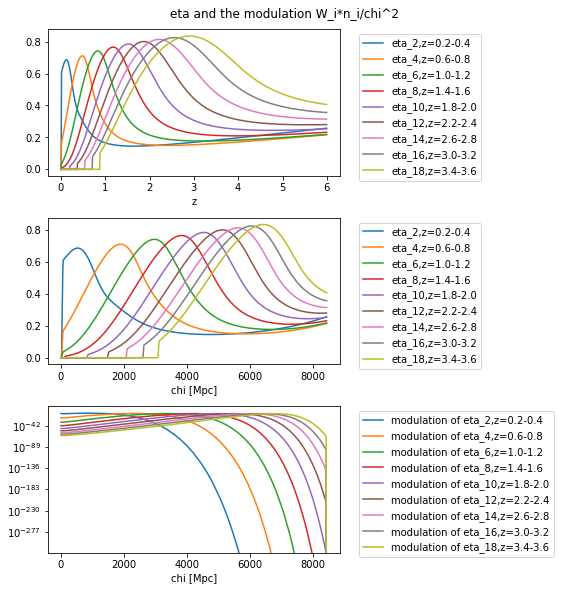

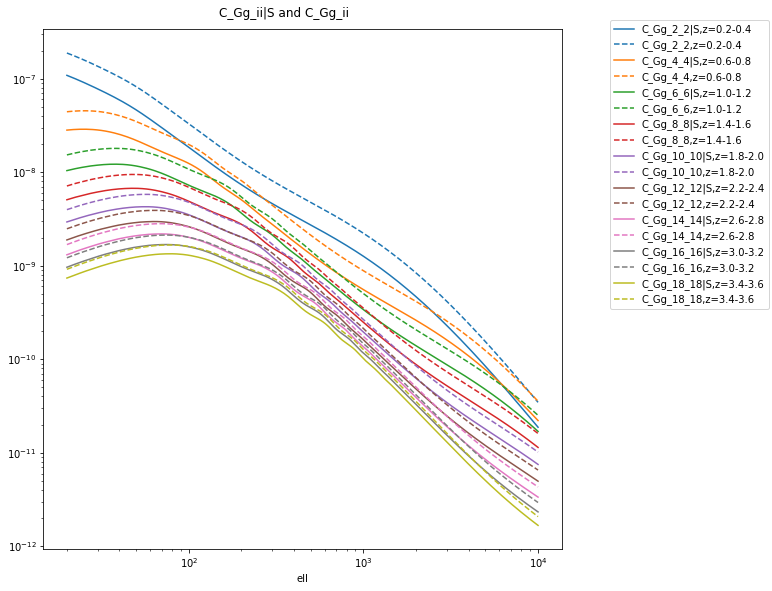

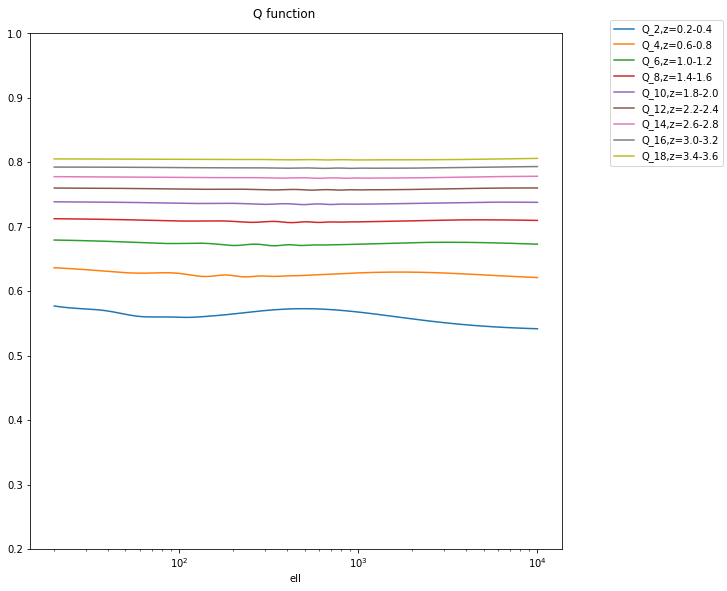

In [34]:
########################################
#Eta Calculations
########################################
print('   - Computing the eta function')

def get_eta_function(BOI,Z_MID,z_i_list_total,n_i_photo_z_total,photo_z_total):
    """
    get the eta function for the bin of interest. (BOI>0)
    will convert eta(z) to etz(chi) at the end
    n_photo_z_data came in as a DataFrame object
    photo_z_total[bin#,truez,photoz] truez form 0-infinity, photoz spans bin i 
    z_i_list_total[bin#,z coordinates in ith bin] 
    """
    
    ################################################
    #get the eta fnc for a single redshift bin
    ################################################
    z_i_list = z_i_list_total[BOI-1]
    photozPDF = photo_z_total[BOI-1]
    n_z_photo_i = n_i_photo_z_total[BOI-1]
    
    eta = 0
    eta_z = np.empty(len(Z_MID),dtype='float64')
#     ui = np.empty(len(Z_MID),dtype='float64')#upper integral
#     li = np.empty(len(Z_MID),dtype='float64')#lower integral

    for z_index in range(len(Z_MID)):
        ################
        #Upper integral with out multiplying the volume element (canceled out when dividing)
        #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
        psnn_zGP = np.empty(len(z_i_list),dtype='float64')
        Wppsnn_2D = np.empty((len(Z_MID),len(z_i_list)),dtype='float64') 
        #Lower integral with out multiplying the volume element (canceled out when dividing)
        #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
        pnn_zGP = np.empty(len(z_i_list),dtype='float64')
        Wppnn_2D = np.empty((len(Z_MID),len(z_i_list)),dtype='float64') 

        for zGP_index in range(len(z_i_list)):
            filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP>0
            filterfunction[filterfunction>0]=0
            filterfunction=filterfunction != 0 #False for entries zgP-zGP>0
            #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
            temp_vec = photozPDF[z_index]*n_z_photo_i[zGP_index]*n_z_photo_i
            psnn_zGP[zGP_index] = np.sum(temp_vec*filterfunction,dtype='float64')
            #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
            pnn_zGP[zGP_index] = np.sum(temp_vec,dtype='float64')

        #Adding the z_G variable and double summation
        for zG_index in range(len(Z_MID)):
            Wppsnn_2D[zG_index] = W_L_list[zG_index,z_index,]*photozPDF[zG_index]*psnn_zGP
            Wppnn_2D[zG_index]  = W_L_list[zG_index,z_index]*photozPDF[zG_index]*pnn_zGP
        Wppsnn_2D_sum = 2*np.sum(Wppsnn_2D,dtype='float64')
        Wppnn_2D_sum  = np.sum(Wppnn_2D,dtype='float64') 

        if Wppnn_2D_sum == 0: increment = 0
        else: increment = Wppsnn_2D_sum/Wppnn_2D_sum
        eta += increment
        eta_z[z_index] = increment
#         ui[z_index] = Wppsnn_2D_sum
#         li[z_index] = Wppnn_2D_sum

    return eta_z



    ########################################
    #Q function Calculations
    ########################################
print('   - Computing the Q function')
fig1, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize = (8,8)) #plotting eta and the modulation for C_Gg_ii|s
fig2, ax4 = plt.subplots(figsize = (8,8)) #plotting the C_Gg_ii|s
fig3, ax5 = plt.subplots(figsize = (8,8)) #plotting the Q function
for i in [1,3,5,7,9,11,13,15,17]:
    BOI = i+1
    print('       - Bin of interest = %i, z = %1.3f-%1.3f'%(BOI,(BOI-1)*deltaz,BOI*deltaz))
    #the weight that goes into the limber integral as a function of z
    
    eta_i_z = get_eta_function(BOI,Z_MID,z_i_list_total,n_i_photo_z_total,photo_z_total)
    eta_i_z_chi_func = interpolate.interp1d(chi_z_func(Z_MID),eta_i_z,kind='linear',bounds_error=0,fill_value=0)
    eta_i_chi = eta_i_z_chi_func(CHI_MID)
    
    limber_weight = (W_i[BOI-1]*n_true_chi_data['BIN%i'%(BOI)]*eta_i_chi)/(CHI_MID**2)
    C_Gg_ii_S_limber = limber_integral(matter_pow_p_k_interpolated,limber_weight,CHI_MID,matter_pow_k_h,ell_list,little_h_chi_func)
    
    limber_weight = (W_i[BOI-1]*n_true_chi_data['BIN%i'%(BOI)])/(CHI_MID**2)
    C_Gg_ii_limber   = limber_integral(matter_pow_p_k_interpolated,limber_weight,CHI_MID,matter_pow_k_h,ell_list,little_h_chi_func)
    
    Q_temp = C_Gg_ii_S_limber/C_Gg_ii_limber
    
    ############
    #PLOTTING  #
    ############
    #sync colors
    color=next(ax1._get_lines.prop_cycler)['color']
    
    #plotting eta and the modulation for C_Gg_ii|s
    ax1.plot(Z_MID,eta_i_z,
             label='eta_%i,z=%1.1f-%1.1f'%(BOI,(BOI-1)*deltaz,BOI*deltaz),c=color)
    ax1.set_xlabel('z')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax2.plot(CHI_MID,eta_i_chi,
             label='eta_%i,z=%1.1f-%1.1f'%(BOI,(BOI-1)*deltaz,BOI*deltaz),c=color)
    ax2.set_xlabel('chi [Mpc]')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax3.plot(CHI_MID,W_i[BOI-1]*n_true_chi_data['BIN%i'%(BOI)]/(CHI_MID**2),
             label='modulation of eta_%i,z=%1.1f-%1.1f'%(BOI,(BOI-1)*deltaz,BOI*deltaz),c=color)
    ax3.set_xlabel('chi [Mpc]')
    ax3.set_yscale('log')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    #plotting the C_Gg_ii|s
    ax4.plot(ell_list,C_Gg_ii_S_limber,
             label='C_Gg_%i_%i|S,z=%1.1f-%1.1f'%(BOI,BOI,(BOI-1)*deltaz,BOI*deltaz),c=color)
    ax4.plot(ell_list,C_Gg_ii_limber,
             label='C_Gg_%i_%i,z=%1.1f-%1.1f'%(BOI,BOI,(BOI-1)*deltaz,BOI*deltaz),linestyle='dashed',c=color)
    ax4.set_xlabel('ell')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    
    #plotting the Q function
    ax5.plot(ell_list,Q_temp,
             label='Q_%i,z=%1.1f-%1.1f'%(BOI,(BOI-1)*deltaz,BOI*deltaz),c=color)
    ax5.set_xlabel('ell')
    ax5.set_xscale('log')
    ax5.set_ylim(0.2,1)
    
fig1.suptitle('eta and the modulation W_i*n_i/chi^2',y=1.02)
fig1.tight_layout()
fig1.savefig(os.path.join(outputpath,'Main_calculations/eta_modulation.png'))
fig1.show()
# plt.close(fig1)    

fig2.suptitle('C_Gg_ii|S and C_Gg_ii',y=1.02)
fig2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig2.tight_layout()
fig2.savefig(os.path.join(outputpath,'Main_calculations/C_Gg_and_C_Gg_S.png'))
fig2.show()
# plt.close(fig2)   

fig3.suptitle('Q function',y=1.02)
fig3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig3.tight_layout()
fig3.savefig(os.path.join(outputpath,'Main_calculations/Q_function.png'))
fig3.show()
# plt.close(fig3) 


